### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../tempHybridSelectionMoreData/'
treated = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 241 ms, sys: 84.5 ms, total: 326 ms
Wall time: 344 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [6]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 1

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [7]:
path_tabs = './res/tabs/'
path_figs = './res/figs/'
path_figs2 = './res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [8]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Treatment']

### Diabetes

In [9]:
#treated[treated.PERS_ID == '2567120'][['MYR', 'ALLOW_IP', 'ALLOW_ER', 'Acute-bin']]

In [10]:
#survTr

In [11]:
%%time
after = 0
grace = 1 # if grace is setted aftere is setted 0 by default
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 4.9 s, sys: 29 ms, total: 4.93 s
Wall time: 4.93 s


In [12]:
survTr

PERS_ID  T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  \
0     2576172  1  1      0     0.0     0.0        1               91   
1     2578414  1  1      0     0.0     1.0        1               87   
2     2578899  1  1      0     0.0     0.0        0               89   
3     2581331  1  1      0     0.0     0.0        0               85   
4     2581848  1  1      0     0.0     2.0        6               89   
...       ... .. ..    ...     ...     ...      ...              ...   
1622  5016688  1  1      0     0.0     1.0        1               30   
1623  5017901  1  1      0     0.0     0.0        0               52   
1624  5018667  1  1      0     0.0     1.0        1               59   
1625  5018913  1  1      0     0.0     1.0        1               54   
1626  5029134  1  1      1     1.0     1.0        1               42   

      ALLOW_AMT  ALLOW_ER  ...  ER_BIN6  ER_C  IP_BIN  IP_BIN2  IP_BIN6  IP_C  \
0           118      0.00  ...      0.0     0       0      0.0      0.0     1   
1          1996      0.00  ...      0.0     0       0      0.0      1.0     1   
2           248      0.00  ...      0.0     0       0      0.0      0.0     0   
3            37      0.00  ...      0.0     0       0      0.0      0.0     0   
4             0      0.00  ...      1.0     2       0      0.0      1.0     4   
...         ...       ...  ...      ...   ...     ...      ...      ...   ...   
1622          0      0.00  ...      0.0     0       0      0.0      1.0     1   
1623         72      0.00  ...      0.0     0       0      0.0      0.0     0   
1624        456      0.00  ...      0.0     0       0      0.0      1.0     1   
1625        711      0.00  ...      0.0     0       0      0.0      1.0     1   
1626      12883   1264.24  ...      1.0     1       0      0.0      0.0     0   

      MBR_GNDR     MYR  PREGNANCY  Treatment  
0          1.0  201908        0.0          1  
1          1.0  201707        0.0          1  
2          0.0  201812        0.0          1  
3          0.0  201610        0.0          1  
4          0.0  202006        0.0          1  
...        ...     ...        ...        ...  
1622       0.0  202005        0.0          1  
1623       1.0  202006        0.0          1  
1624       0.0  202003        0.0          1  
1625       0.0  202005        0.0          1  
1626       0.0  202004        0.0          1  

[1627 rows x 91 columns]

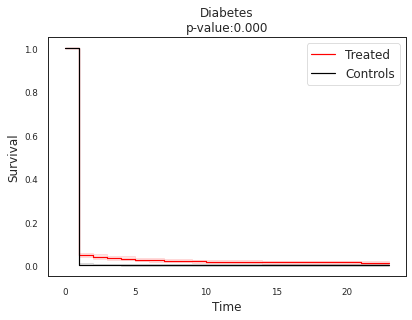

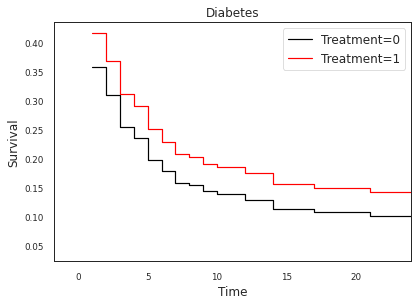

In [13]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title)

In [14]:
lrsumm

test_statistic             p   -log2(p)
Diabetes       31.782343  1.724534e-08  25.789218

In [15]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -0.075           0.135       -0.557    0.578
Gender               0.032           0.037        0.880    0.379
Total Cost           0.013           0.008        1.615    0.106
Tobacco use         -0.010           0.056       -0.172    0.863
Obesity             -0.019           0.042       -0.460    0.646
Hypertension         0.023           0.046        0.493    0.622
Hypothyroid         -0.007           0.066       -0.106    0.916
Disease Count        0.640           0.191        3.349    0.001
Treatment           -0.160           0.037       -4.324    0.000

### ER

In [16]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [17]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace, onset = onset).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])

survCo = data[1].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 4.81 s, sys: 32.8 ms, total: 4.85 s
Wall time: 4.85 s


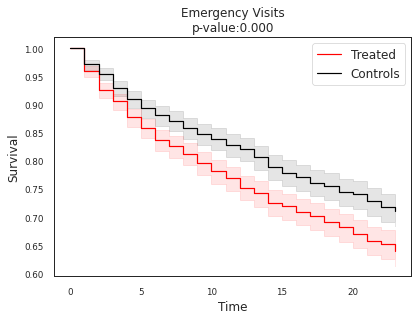

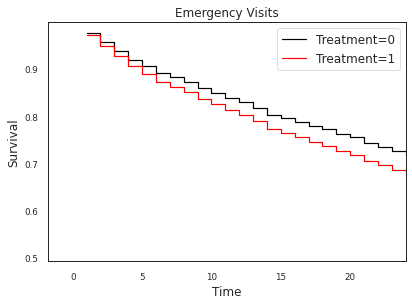

In [18]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [19]:
lrsumm

test_statistic         p   -log2(p)
Emergency Visits       16.825537  0.000041  14.574786

In [20]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -1.994           0.225       -8.857    0.000
Gender              -0.215           0.062       -3.462    0.001
Total Cost           0.022           0.014        1.597    0.110
Tobacco use          0.476           0.080        5.930    0.000
Obesity             -0.143           0.068       -2.101    0.036
Hypertension        -0.055           0.078       -0.708    0.479
Hypothyroid         -0.227           0.109       -2.093    0.036
Disease Count        3.160           0.308       10.253    0.000
Treatment            0.164           0.062        2.642    0.008

### IP

In [21]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [22]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 4.79 s, sys: 6.29 ms, total: 4.8 s
Wall time: 4.8 s


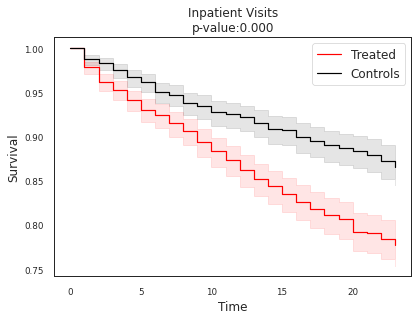

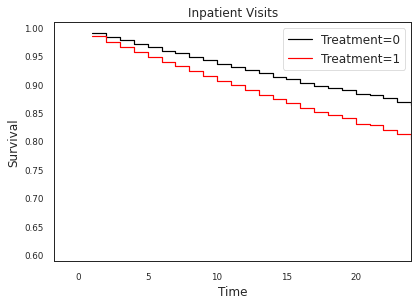

In [23]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [24]:
lrsumm

test_statistic             p   -log2(p)
Inpatient Visits       34.982884  3.326162e-09  28.163494

In [25]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -0.106           0.309       -0.343    0.732
Gender               0.021           0.078        0.275    0.783
Total Cost           0.082           0.020        4.125    0.000
Tobacco use          0.176           0.103        1.704    0.088
Obesity             -0.387           0.085       -4.567    0.000
Hypertension         0.062           0.100        0.620    0.535
Hypothyroid         -0.146           0.125       -1.169    0.242
Disease Count        4.317           0.357       12.095    0.000
Treatment            0.398           0.079        5.009    0.000

### Acute Care IP OR ER

In [26]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [27]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True).dropna(axis = 0, subset = ['PERS_ID'])


CPU times: user 4.88 s, sys: 5.89 ms, total: 4.89 s
Wall time: 4.89 s


In [28]:
survTr[survTr.E >0]

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  \
1     2578414   4  1      0     0.0     1.0        1               87   
5     2582630  23  1      0     0.0     0.0        0               84   
7     2583925  27  1      0     0.0     0.0        0               85   
8     2588409  49  1      0     0.0     0.0        0               82   
10    2590558   4  1      0     0.0     0.0        0               81   
...       ...  .. ..    ...     ...     ...      ...              ...   
1614  4378736   7  1      0     0.0     2.0        2               46   
1615  4386027   2  1      0     0.0     1.0        1               27   
1616  4387489   5  1      0     0.0     0.0        0               63   
1619  4399083   1  1      1     2.0     3.0        4               25   
1626  5029134   1  1      1     1.0     1.0        1               42   

      ALLOW_AMT  ALLOW_ER  ...  ER_BIN6  ER_C  IP_BIN  IP_BIN2  IP_BIN6  IP_C  \
1          1996      0.00  ...      0.0     0       0      0.0      1.0     1   
5           306      0.00  ...      0.0     0       0      0.0      0.0     0   
7          2103      0.00  ...      0.0     0       0      0.0      0.0     0   
8           327      0.00  ...      0.0     0       0      0.0      0.0     0   
10         1362      0.00  ...      0.0     0       0      0.0      0.0     0   
...         ...       ...  ...      ...   ...     ...      ...      ...   ...   
1614        998      0.00  ...      1.0     1       0      0.0      2.0     2   
1615        191      0.00  ...      0.0     0       0      0.0      1.0     1   
1616       1715      0.00  ...      0.0     0       0      0.0      0.0     0   
1619        249    174.22  ...      2.0     3       0      0.0      1.0     1   
1626      12883   1264.24  ...      1.0     1       0      0.0      0.0     0   

      MBR_GNDR     MYR  PREGNANCY  Treatment  
1          1.0  201707        0.0          1  
5          0.0  201604        0.0          1  
7          0.0  201710        0.0          1  
8          0.0  201602        0.0          1  
10         0.0  201604        0.0          1  
...        ...     ...        ...        ...  
1614       1.0  201904        0.0          1  
1615       1.0  201906        0.0          1  
1616       0.0  201903        0.0          1  
1619       0.0  202004        0.0          1  
1626       0.0  202004        0.0          1  

[787 rows x 92 columns]

In [29]:
treated[treated.PERS_ID == '4386027'][['IP_BIN','ER_BIN']]

IP_BIN  ER_BIN
51146       0       0
51147       0       0
51148       1       0
51149       0       1
51150       0       0
51151       0       0
51152       0       0
51153       0       0
51154       0       0
51155       0       0
51156       0       0
51157       0       0
51158       0       1
51159       0       0

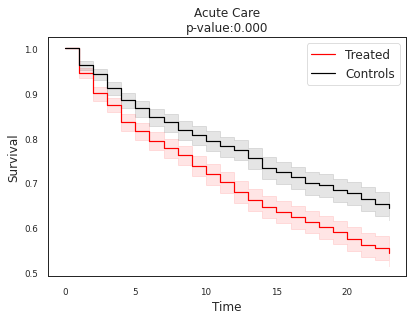

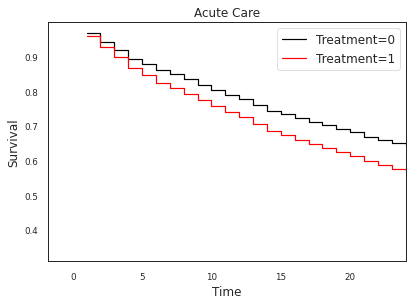

In [30]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title)

In [31]:
lrsumm

test_statistic             p   -log2(p)
Acute Care        31.71138  1.788710e-08  25.736506

In [32]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -1.534           0.206       -7.456    0.000
Gender              -0.177           0.056       -3.182    0.001
Total Cost           0.047           0.013        3.604    0.000
Tobacco use          0.414           0.073        5.669    0.000
Obesity             -0.201           0.061       -3.296    0.001
Hypertension        -0.015           0.070       -0.222    0.824
Hypothyroid         -0.269           0.097       -2.788    0.005
Disease Count        3.436           0.276       12.461    0.000
Treatment            0.244           0.055        4.397    0.000

### Load all Log Rank Sums in a matrix

In [33]:
from pathlib import Path
p = Path('./res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('./res/tabs/all_logrank.csv')


In [34]:
df2

logRank statistic       p-value  RMST difference
Diabetes                  31.782343  1.724534e-08         0.411673
Emergency Visits          16.825537  4.097813e-05        -1.216884
Inpatient Vistis          34.982884  3.326162e-09        -1.265662
Acute Care                31.711380  1.788710e-08        -1.713827